In [1]:
import sys 
sys.path.append('../')
from itertools import repeat
import pandas as pd 
import numpy as np 
from scipy.stats import mode
import talib
import sqlite3 as sql
import tulipy
from p_tqdm import p_map, p_umap, t_map
from tqdm.notebook import tqdm_notebook
from backtester import * 
from fxcmtoken import my_assets

In [2]:
for i, v in enumerate(my_assets):
    print(i, '|', v)

0 | EUR/USD
1 | USD/JPY
2 | GBP/USD
3 | USD/CHF
4 | AUD/USD
5 | USD/CAD
6 | NZD/USD
7 | Bund
8 | AUS200
9 | ESP35
10 | EUSTX50
11 | FRA40
12 | GER30
13 | HKG33
14 | JPN225
15 | NAS100
16 | SPX500
17 | UK100
18 | US30
19 | Copper
20 | NGAS
21 | UKOil
22 | USOil
23 | XAU/USD
24 | XAG/USD


In [3]:
def get_slope_signals(data, param, start, end):
    if param[0] in [None, np.nan]: return np.nan
    if param[1] in [None, np.nan]: return np.nan
    
    data = data.copy(deep=True)
    
    try:
        data["param1"] = np.nan
        param1 = tulipy.linregslope(data.close.values, param[0])
        data.iloc[-len(param1):,data.columns.get_loc("param1")] = param1

        data["param2"] = np.nan
        param2 = tulipy.linregslope(data.close.values, param[1])
        data.iloc[-len(param2):,data.columns.get_loc("param2")] = param2
    except:
        return np.nan
    
    data.dropna(axis=0, inplace=True)
    data['signal'] = np.where(data["param1"] > data["param2"], 1,
                               np.where(data["param1"] < data["param2"], -1, np.nan)
                              )
    data['signal'] = data['signal'].ffill()
    data = data.loc[start:end]
    if len(data) == 0:
        return np.nan
    else:
        return data


def get_strategy_return(data, param, freq, start, end):    
    data = get_slope_signals(data, param, start, end)
    if not isinstance(data, pd.DataFrame): return (param, np.nan)
    if len(data) == 0: return (param, np.nan)
    backtester = IterativeBacktester(data=data, signals=data.signal, freq=freq)
    backtester.backtest(progress_bar=False)

    return param, backtester.return_df.loc['TotalReturn', 'Portfolio']


def get_optim_param(data, params, freq, start, end): 
    try:
        res = t_map(get_strategy_return, repeat(data), params, repeat(freq), 
                     repeat(start), repeat(end), leave=False)

        res = pd.DataFrame(res, columns=['params', 'returns'])
        res.sort_values(by='returns', ascending=False, inplace=True)
        best = res.iloc[0]
    except:
        return
    
    return start, end, best['params'], best['returns'] 

In [4]:
params = []
for i in np.arange(10, 101, 10):
    for j in np.arange(10, 101, 10):
        if i < j: params.append((i,j))
print(len(params))

45


In [5]:
freq = 'H1'
sql_path = f'PriceData_{freq}.db'
conn = sql.connect(sql_path)
ticker = my_assets[5]
data_sql = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
for col in ['open', 'close', 'high', 'low']:
    data_sql[col] = data_sql[['bid'+col, 'ask'+col]].mean(axis=1)
print(ticker)
data_sql.info()

USD/CAD
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2021-01-15 06:00:00 to 2022-08-12 20:00:00
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bidopen   10000 non-null  float64
 1   bidclose  10000 non-null  float64
 2   bidhigh   10000 non-null  float64
 3   bidlow    10000 non-null  float64
 4   askopen   10000 non-null  float64
 5   askclose  10000 non-null  float64
 6   askhigh   10000 non-null  float64
 7   asklow    10000 non-null  float64
 8   tickqty   10000 non-null  int64  
 9   open      10000 non-null  float64
 10  close     10000 non-null  float64
 11  high      10000 non-null  float64
 12  low       10000 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.1 MB


In [6]:
sat_index = data_sql.resample('W-Sat').last().index
start_dates = []
end_dates = []
for i in range(1, len(sat_index)-1):
    start_dates.append(sat_index[i])
    end_dates.append(sat_index[i+1])

In [7]:
optim_params = p_umap(get_optim_param, repeat(data_sql), repeat(params), repeat(freq), start_dates, end_dates, leave=False)
opt_df = pd.DataFrame(optim_params, columns=['starts', 'ends', 'params', 'returns'])
opt_df.sort_values(by='starts', ascending=True, inplace=True)
opt_df.reset_index(inplace=True, drop=True)
optim_winrate = opt_df.returns.apply(np.sign).value_counts(normalize=True)[1]
optim_ret = opt_df.returns.mean()

opt_df['param1'] = opt_df.params.apply(lambda x: x[0] if x is not None else None)
opt_df['param2'] = opt_df.params.apply(lambda x: x[1] if x is not None else None)

print(f'Ticker: {ticker}')
print(f"winrate: {optim_winrate*100:.2f} %\nreturn: {optim_ret*100:.2f} %")

  0%|          | 0/81 [00:00<?, ?it/s]

Ticker: USD/CAD
winrate: 98.77 %
return: 1.32 %


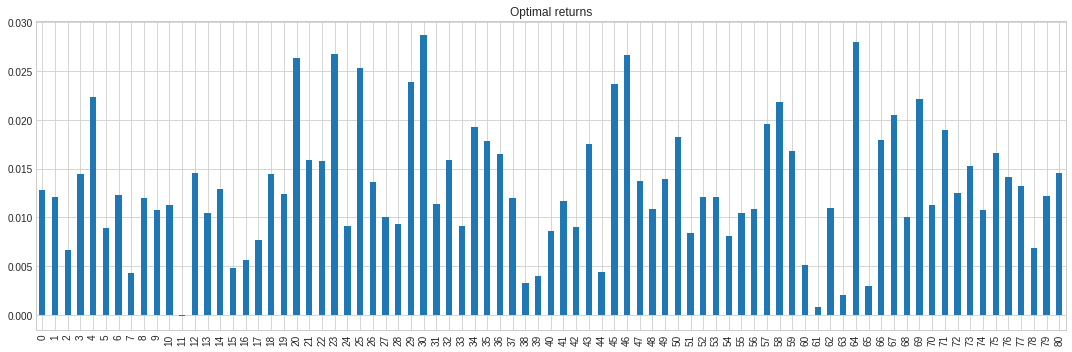

In [8]:
opt_df.returns.plot(kind='bar', figsize=(15,5), title='Optimal returns')
plt.tight_layout()
plt.show()

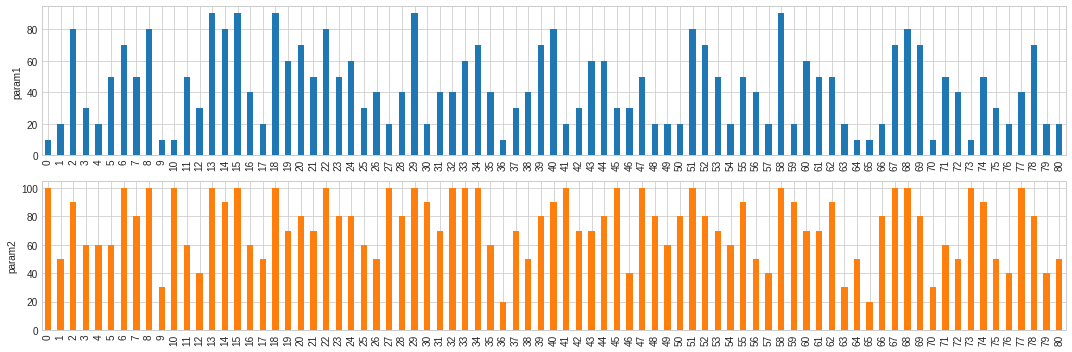

In [9]:
fig, ax = plt.subplots(2, 1)
opt_df['param1'].plot(kind='bar', figsize=(15,5), ax=ax[0], color='tab:blue')
ax[0].set_ylabel('param1')

opt_df['param2'].plot(kind='bar', figsize=(15,5), ax=ax[1], color='tab:orange')
ax[1].set_ylabel('param2')
plt.tight_layout()
plt.show()

In [10]:
print(len(start_dates), int(len(start_dates)*0.7))

81 56


In [11]:
n_periods = [i for i in range(1, int(len(start_dates)*0.7), 1)]

results = []
for n in tqdm_notebook(n_periods):
    param1_roll_median = opt_df.param1.iloc[:-1].rolling(n).median()
    param1_roll_mean = opt_df.param1.iloc[:-1].rolling(n).mean()
    param1_roll_mode = opt_df.param1.iloc[:-1].rolling(n).apply(lambda x: mode(x)[0])
    
    param2_roll_median = opt_df.param2.iloc[:-1].rolling(n).median()
    param2_roll_mean = opt_df.param2.iloc[:-1].rolling(n).mean()
    param2_roll_mode = opt_df.param2.iloc[:-1].rolling(n).apply(lambda x: mode(x)[0])

    # median
    param1_p = param1_roll_median.values
    param2_p = param2_roll_median.values
    param2_p = np.where(param2_p < 0.01, 0.01, param2_p)
    params = [*zip(param1_p, param2_p)]
    test_returns =  p_umap(get_strategy_return, repeat(data_sql), params, repeat(freq), 
                            start_dates[-len(params):], end_dates[-len(params):], leave=False)
    test_returns = pd.DataFrame(test_returns, columns=['params', 'returns'])
    median_winrate = test_returns.returns.apply(np.sign).value_counts(normalize=True)[1]
    median_ret = test_returns.returns.mean()
    results.append(('median', n, median_winrate, median_ret))
    
    # mean
    param1_p = param1_roll_mean.values
    param2_p = param2_roll_mean.values
    param2_p = np.where(param2_p < 0.01, 0.01, param2_p)
    params = [*zip(param1_p, param2_p)]
    test_returns =  p_umap(get_strategy_return, repeat(data_sql), params, repeat(freq), 
                            start_dates[-len(params):], end_dates[-len(params):], leave=False)
    test_returns = pd.DataFrame(test_returns, columns=['params', 'returns'])
    mean_winrate = test_returns.returns.apply(np.sign).value_counts(normalize=True)[1]
    mean_ret = test_returns.returns.mean()
    results.append(('mean', n, mean_winrate, mean_ret))
    
    # mode
    param1_p = param1_roll_mode.values
    param2_p = param2_roll_mode.values
    param2_p = np.where(param2_p < 0.01, 0.01, param2_p)
    params = [*zip(param1_p, param2_p)]
    test_returns =  p_umap(get_strategy_return, repeat(data_sql), params, repeat(freq), 
                            start_dates[-len(params):], end_dates[-len(params):], leave=False)
    
    test_returns = pd.DataFrame(test_returns, columns=['params', 'returns'])
    mode_winrate = test_returns.returns.apply(np.sign).value_counts(normalize=True)[1]
    mode_ret = test_returns.returns.mean()
    results.append(('mode', n, mode_winrate, mode_ret))

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [12]:
res_df = pd.DataFrame(results, columns = ['agg_methods', 'n_periods', 'win_rates', 'returns'])
res_df.sort_values(by='returns', ascending=False, inplace=True)
res_df.reset_index(inplace=True, drop=True)

In [13]:
res_df.sort_values(by='returns', ascending=False).head()

,agg_methods,n_periods,win_rates,returns
0,median,5,0.552632,0.000119
1,median,10,0.521127,-0.000109
2,mode,17,0.515625,-0.000134
3,mode,18,0.507937,-0.000245
4,mean,42,0.538462,-0.000283


In [14]:
res_df.sort_values(by='win_rates', ascending=False).head()

,agg_methods,n_periods,win_rates,returns
29,mode,47,0.588235,-0.000779
43,mode,46,0.571429,-0.000950
42,median,28,0.566038,-0.000949
136,mode,54,0.555556,-0.002014
8,mean,45,0.555556,-0.000423


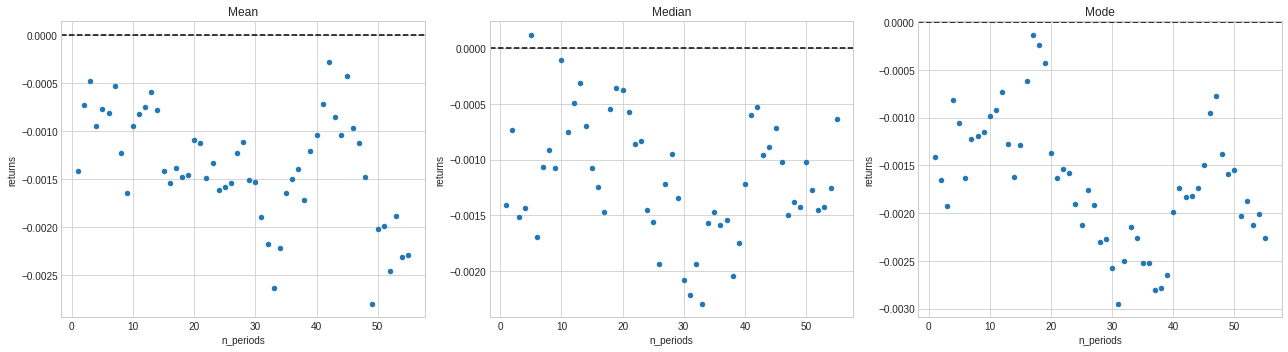

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
res_df.query("agg_methods=='mean'").plot(kind='scatter', x='n_periods', y='returns', ax=ax[0])
ax[0].axhline(y=0, color='k', linestyle='--')
ax[0].set_title('Mean')

res_df.query("agg_methods=='median'").plot(kind='scatter', x='n_periods', y='returns', ax=ax[1])
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].set_title('Median')

res_df.query("agg_methods=='mode'").plot(kind='scatter', x='n_periods', y='returns', ax=ax[2])
ax[2].axhline(y=0, color='k', linestyle='--')
ax[2].set_title('Mode')

plt.tight_layout()
plt.show()

In [16]:
pos_ret = res_df.query('returns > 0')
pos_ret.head()

,agg_methods,n_periods,win_rates,returns
0,median,5,0.552632,0.000119


In [17]:
best_agg = pos_ret.loc[0].agg_methods
best_n = pos_ret.loc[0].n_periods
print(best_agg, best_n)

median 5


In [18]:
# group by agg_methods
ret_by_aggs = res_df.query('returns > 0')[['agg_methods', 'returns']].groupby('agg_methods').mean()
ret_by_aggs

,returns
agg_methods,
median,0.000119


In [19]:
# counting the number of positive returns for each agg_methods
pos_ret_count = {}
for method in ['mean', 'median', 'mode']:
    pos_ret_count[method] = res_df.query(f"agg_methods=='{method}' and returns > 0").shape[0]
    
pos_ret_count

{'mean': 0, 'median': 1, 'mode': 0}

In [20]:
pos_best_agg = res_df.query(f'returns > 0 and agg_methods=="{best_agg}"')
pos_best_agg

,agg_methods,n_periods,win_rates,returns
0,median,5,0.552632,0.000119


In [21]:
pos_best_agg.query('n_periods == @best_n')

,agg_methods,n_periods,win_rates,returns
0,median,5,0.552632,0.000119


In [22]:
agg = best_agg
n = best_n

param1_roll_median = opt_df.param1.iloc[:-1].rolling(n).median()
param1_roll_mean = opt_df.param1.iloc[:-1].rolling(n).mean()
param1_roll_mode = opt_df.param1.iloc[:-1].rolling(n).apply(lambda x: mode(x)[0])

param2_roll_median = opt_df.param2.iloc[:-1].rolling(n).median()
param2_roll_mean = opt_df.param2.iloc[:-1].rolling(n).mean()
param2_roll_mode = opt_df.param2.iloc[:-1].rolling(n).apply(lambda x: mode(x)[0])

# median
if agg == 'median':
    param1_p = param1_roll_median.values
    param2_p = param2_roll_median.values
    param2_p = np.where(param2_p < 0.01, 0.01, param2_p)
    params = [*zip(param1_p, param2_p)]
    test_returns =  p_umap(get_strategy_return, repeat(data_sql), params, repeat(freq), 
                            start_dates[-len(params):], end_dates[-len(params):], leave=False)
    test_returns = pd.DataFrame(test_returns, columns=['params', 'returns'])
    winrate = test_returns.returns.apply(np.sign).value_counts(normalize=True)[1]
    ret = test_returns.returns.mean()

# mean
if agg == 'mean':
    param1_p = param1_roll_mean.values
    param2_p = param2_roll_mean.values
    param2_p = np.where(param2_p < 0.01, 0.01, param2_p)
    params = [*zip(param1_p, param2_p)]
    test_returns =  p_umap(get_strategy_return, repeat(data_sql), params, repeat(freq), 
                            start_dates[-len(params):], end_dates[-len(params):], leave=False)
    test_returns = pd.DataFrame(test_returns, columns=['params', 'returns'])
    winrate = test_returns.returns.apply(np.sign).value_counts(normalize=True)[1]
    ret = test_returns.returns.mean()

# mode
if agg == 'mode':
    param1_p = param1_roll_mode.values
    param2_p = param2_roll_mode.values
    param2_p = np.where(param2_p < 0.01, 0.01, param2_p)
    params = [*zip(param1_p, param2_p)]
    test_returns =  p_umap(get_strategy_return, repeat(data_sql), params, repeat(freq), 
                            start_dates[-len(params):], end_dates[-len(params):], leave=False)
    test_returns = pd.DataFrame(test_returns, columns=['params', 'returns'])
    winrate = test_returns.returns.apply(np.sign).value_counts(normalize=True)[1]
    ret = test_returns.returns.mean()

  0%|          | 0/80 [00:00<?, ?it/s]

Ticker: USD/CAD
Aggregate method: median
n-period: 5
winrate: 55.2632 %
return: 0.0119 %
Cumulative return: 0.9058 %


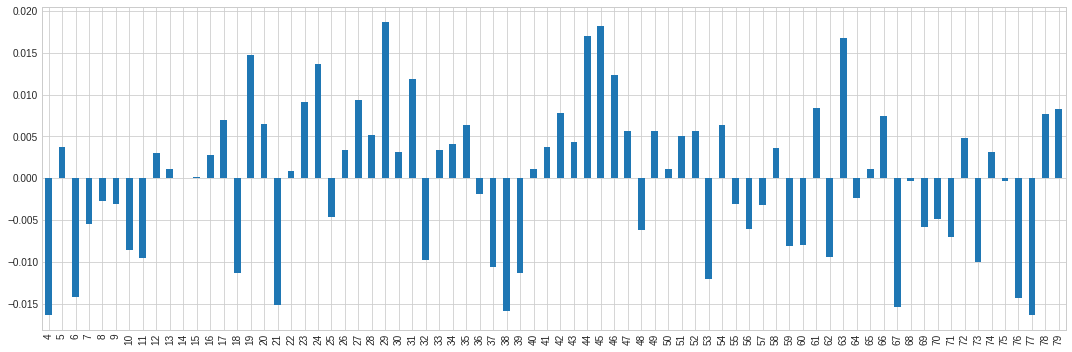

In [23]:
print(f'Ticker: {ticker}')
print(f"Aggregate method: {agg}\nn-period: {n}")
print(f"winrate: {winrate*100:.4f} %\nreturn: {ret*100:.4f} %")
print(f"Cumulative return: {test_returns.returns.dropna().sum()*100:.4f} %")
test_returns.returns.dropna().plot(kind='bar', figsize=(15,5))
plt.tight_layout()
plt.show()